<center><h1> Webscraping Project - Steam</h1> </center>

<center><h3> Yuki Chen & Liz Meng</h3> </center>

# Table of Contents

1. [Install Selenium & Required Libraries](#1.-Install-Selenium-&-Required-Libraries)
2. [Setting up Selenium](#2.-Setting-up-Selenium)
3. [Data Scraping](#3.-Data-Scraping)
4. [Data Cleanup](#4.-Data-Cleanup)
5. [Analysis and Graphics](#5.-Analysis-and-Graphics)

## 1. Install Selenium & Required Libraries

### 1.1 Install Selenium

In [1]:
!pip install selenium

In [ ]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import Select
from selenium.common.exceptions import NoSuchElementException

### 1.2 Install Libraries

In [1]:
from tqdm import tqdm
from time import sleep
import datetime
import re

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## 2. Setting up Selenium

In [858]:
driver = webdriver.Chrome('C:/Users/yuki-/Documents/DS Bootcamp/Lectures/python/chromedriver.exe')

C:\Users\yuki-\AppData\Local\Temp\ipykernel_34192\2675890558.py:1: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome('C:/Users/yuki-/Documents/DS Bootcamp/Lectures/python/chromedriver.exe')


<h3>2.1 Go to Page</h3>

In [859]:
driver.get("https://store.steampowered.com/")

<h4>2.1.1 Set Language</h4>

My computer has different language settings so setting the default back to English

In [860]:
driver.find_element(By.XPATH,'//*[@id="language_pulldown"]').click()

In [861]:
select = driver.find_element(By.XPATH,'//*[@id="language_dropdown"]/div/a[9]').click()

<h3>2.2 Naviage to Top Sellers</h3>

In [862]:
driver.find_element(By.XPATH,'//*[@id="responsive_page_template_content"]/div[1]/div[1]/div/div[1]/div[8]/a[1]').click()

In [863]:
# unapply filter to get most results
driver.find_element(By.XPATH,'//*[@id="search_results_filtered_warning_persistent"]/div[2]').click()
sleep(3)
driver.find_element(By.XPATH,'/html/body/div[3]/div[3]/div/div[2]/div[1]').click()

## 3. Data Scraping

### 3.1 Create Dictionary to Store Values

In [127]:
top1 = {'name':[],
      'price':[],
      'discount_price':[],
      'release_date':[],
      'review_count':[],
      'review_quality':[],
      'genre': [],
      'rating':[],
      'developer':[],
      'publisher':[],
      'player_support':[],
      'deck_support': []
     }

### 3.2 Find number of items on the page

<p>Steam is a dynamic page that implements infinite scroll, and each item is listed by an index in its XPath. In order to find all items on the page, use Selenium to scroll all the way to the bottom and find number of items loaded.</p>

In [93]:
for i in tqdm(range(130)):
    # scrolling all the way to bottom (infinite scroll)
    driver.execute_script('window.scrollTo(0,document.body.scrollHeight);')
    sleep(2)


  # find number of items
d = driver.find_elements(By.CLASS_NAME,'search_result_row')

100%|██████████| 130/130 [04:27<00:00,  2.06s/it]


### 3.3 Crawling Data

Loop Process:
1. Need to open each game in its own page to gather important information such as rating, publisher, reviews that are not shown on the seach page
2. Open the page in a new tab to avoid refreshing the search page such that it hides elements that are not loaded
3. Scrape necessary information from page
4. Close the tab and return to search page
5. Open next page

In [132]:
# Initialize the page number
page = 0

# Set up for loop to iterate through all items on the search page
for a in tqdm(range(len(d))):
    sleep(2)
    # get url of link to the item
    u = driver.find_element(By.XPATH,f'//*[@id="search_resultsRows"]/a[{a+1}]').get_attribute('href')
    
    # open link in new tab (to not let the previous page reload)
    driver.execute_script("window.open('');")
    driver.switch_to.window(driver.window_handles[1])
    driver.get(u)
    
    
    # set appropriate age to bypass age restriction
    try:
        select = Select(driver.find_element(By.ID,'ageYear'))
        sleep(2)
        select.select_by_index(96)
        sleep(1)
        driver.find_element(By.XPATH,'//*[@id="view_product_page_btn"]').click()
    except:
        # no age restriction - proceed to page
        try:
            sleep(3)
            driver.refresh()
            name = driver.find_element(By.XPATH,'//*[@id="appHubAppName"]').text
        except:
            # page unavailable - close page and proceed to next item
            sleep(1)
            driver.close()
            driver.switch_to.window(driver.window_handles[0])
            continue
    
    # scrape data
    # name
    try:
        name = driver.find_element(By.XPATH,'//*[@id="appHubAppName"]').text
    except:
        name = 'missing'
        
    # price and discount price of available
    try:
        price = driver.find_element(By.CLASS_NAME,'game_purchase_price').text
        discount_price = 'missing'
        if price == '':
            try:
                price = driver.find_element(By.CLASS_NAME,'discount_original_price').text
                discount_price = driver.find_element(By.CLASS_NAME,'discount_final_price').text
            except:
                price = 'missing'
                discount_price = 'missing'
    except:
        # when there is discount available
        try:
            price = driver.find_element(By.CLASS_NAME,'discount_original_price').text
            discount_price = driver.find_element(By.CLASS_NAME,'discount_final_price').text
        except:
            price = 'missing'
            discount_price = 'missing'
                
    # release date
    try:
        release_date = driver.find_element(By.CLASS_NAME,'date').text
    except:
        release_date = 'missing'
        
    # review count
    try:
        review_count = driver.find_element(By.XPATH,'//*[@id="userReviews"]/div[2]/div[2]/span[2]').text
    except:
        # element in a different div
        try:
            review_count = driver.find_element(By.XPATH,'//*[@id="userReviews"]/div/div[2]/span[2]').text
        except:
            review_count = 'missing'
      
    # review quality
    try:
        review_quality = driver.find_element(By.XPATH,'//*[@id="userReviews"]/div[2]/div[2]/span[1]').text
    except:
        # element in a different div
        try:
            review_quality = driver.find_element(By.XPATH,'//*[@id="userReviews"]/div/div[2]/span[1]').text
        except:
            review_quality = 'missing'
     
    # genre: a game can have multiple genres
    driver.execute_script("window.scrollTo(0, 1000);")
    try:
        genre = driver.find_element(By.XPATH,'//*[@id="genresAndManufacturer"]/span').text
    except:
        genre = 'missing'
            
    # rating 
    try:
        rating = driver.find_element(By.XPATH,'//*[@id="tabletGrid"]/div[1]/div[5]/div[1]/div[11]/div[2]/div[1]/div[1]/img').get_attribute('src')[-5]
    except:
        rating = 'missing'
    
    # developer
    try:
        developer = driver.find_element(By.XPATH,'//*[@id="genresAndManufacturer"]/div[1]/a').text
    except:
        developer = 'missing'
        
    # publisher
    try:
        publisher = driver.find_element(By.XPATH,'//*[@id="genresAndManufacturer"]/div[2]/a').text
    except:
        publisher = 'missing'
        
    # player_support
    try:
        player_support = driver.find_element(By.XPATH,'//*[@id="category_block"]/div[1]/a[1]/div[2]').text
    except:
        player_support = 'missing'
    
    # steam deck support
    try:
        deck_support = driver.find_element(By.XPATH,'//*[@id="tabletGrid"]/div[1]/div[5]/div[1]/div[10]/div/div[2]/div[1]/span').text
    except:
        deck_support = 'missing'
              
        
    # append to dict
    top1['name'].append(name)
    top1['price'].append(price)
    top1['discount_price'].append(discount_price)
    top1['release_date'].append(release_date)
    top1['review_count'].append(review_count)
    top1['review_quality'].append(review_quality)
    top1['genre'].append(genre)
    top1['rating'].append(rating)
    top1['developer'].append(developer)
    top1['publisher'].append(publisher)
    top1['player_support'].append(player_support)
    top1['deck_support'].append(deck_support)
    
        
    # go back to previous page
    sleep(1)
    driver.close()
    driver.switch_to.window(driver.window_handles[0])
    
    # page count
    page += 1
    
    # save to csv every 50 pages
    if page % 50 == 0:
        # scroll down to batch
        driver.execute_script('window.scrollTo(0,document.body.scrollHeight);')
        # save data to dataframe
        df = pd.DataFrame(top1)
        df.to_csv('games.csv',index=False,mode='a',header=False)
        # initialize dictionary for next iteration
        top1 = {'name':[],
                'price':[],
                'discount_price':[],
                'release_date':[],
                'review_count':[],
                'review_quality':[],
                'genre': [],
                'rating':[],
                'developer':[],
                'publisher':[],
                'player_support':[],
                'deck_support': []
                 }
        
    # for last few pages
    if page == len(d):
        # save to dataframe
        df = pd.DataFrame(top1)
        df.to_csv('games.csv',index=False,mode='a',header=False)

 75%|███████▌  | 4820/6411 [13:27:46<4:26:38, 10.06s/it] 


KeyboardInterrupt: 

In [133]:
# test: check dictionary
top1

{'name': ['ENDLESS™ Space 2 - Original Soundtrack',
  'Nancy Drew®: The Haunting of Castle Malloy',
  'Caravaneer 2',
  'Music for The Long Dark -- Volume Two',
  'Outlaws + A Handful of Missions',
  'Big Pharma',
  'Frontline: The Great Patriotic War'],
 'price': ['CDN$ 7.70',
  'CDN$ 7.99',
  'CDN$ 6.69',
  'CDN$ 8.99',
  'CDN$ 6.69',
  'CDN$ 28.99',
  'CDN$ 6.69'],
 'discount_price': ['CDN$ 3.85',
  'missing',
  'missing',
  'missing',
  'missing',
  'missing',
  'CDN$ 2.67'],
 'release_date': ['3 Jul, 2020',
  '1 Mar, 2009',
  '7 Dec, 2014',
  '19 May, 2020',
  '31 Mar, 1997',
  '27 Aug, 2015',
  '20 Dec, 2019'],
 'review_count': ['', '(120)', '(293)', '(20)', '(435)', '(1,310)', '(19)'],
 'review_quality': ['4 user reviews',
  'Very Positive',
  'Very Positive',
  'Positive',
  'Very Positive',
  'Mostly Positive',
  'Positive'],
 'genre': ['Strategy',
  'Adventure',
  'Indie, RPG, Simulation, Strategy',
  'missing',
  'Action',
  'Indie, Simulation, Strategy',
  'Action, Adventur

In [134]:
# test: check data frame
df = pd.DataFrame(top1)

In [135]:
# test: check csv generated
df.to_csv('games.csv',index=False,mode='a',header=False)

### 3.4 Reading csv Into Pandas DataFrame

In [138]:
# re-assign headings
games = pd.read_csv('games.csv',names=['name','price','discount_price','release_date','review_count','review_quality','genre','rating','dev','publisher','player_sup','deck_sup'])

In [191]:
games.head()

,name,price,discount_price,release_date,review_count,review_quality,genre,rating,dev,publisher,player_sup,deck_sup
0,Counter-Strike: Global Offensive,Free to Play,missing,"21 Aug, 2012","(6,685,816)",Very Positive,"Action, Free to Play",missing,Valve,Valve,Steam Achievements,Playable
1,EA SPORTS™ FIFA 23,CDN$ 89.99,missing,"29 Sep, 2022","(11,982)",Mostly Negative,"Simulation, Sports",e,EA Canada & EA Romania,Electronic Arts,Single-player,Unsupported
2,Lost Ark,Free To Play,missing,"11 Feb, 2022","(173,200)",Mostly Positive,"Action, Adventure, Free to Play, Massively Mul...",m,Smilegate RPG,Amazon Games,Single-player,Unsupported
3,Apex Legends™,Free to Play,missing,"4 Nov, 2020","(518,577)",Very Positive,"Action, Adventure, Free to Play",t,Respawn Entertainment,Electronic Arts,Online PvP,Verified
4,Cyberpunk 2077,CDN$ 79.99,missing,"9 Dec, 2020","(419,833)",Mostly Positive,RPG,m,CD PROJEKT RED,CD PROJEKT RED,Single-player,Playable


In [192]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5008 entries, 0 to 5007
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   name            5008 non-null   object
 1   price           5005 non-null   object
 2   discount_price  5008 non-null   object
 3   release_date    5008 non-null   object
 4   review_count    4787 non-null   object
 5   review_quality  5008 non-null   object
 6   genre           5008 non-null   object
 7   rating          5008 non-null   object
 8   dev             5008 non-null   object
 9   publisher       5008 non-null   object
 10  player_sup      5008 non-null   object
 11  deck_sup        5008 non-null   object
dtypes: object(12)
memory usage: 469.6+ KB


## 4. Data Cleanup

### 4.1 Convert `str` type to `int` in `review_counts` column

In [224]:
# make a copy of original data frame
games_cp = games.copy()

In [239]:
# define function to remove '()' from string in review counts
def replace_s(s):
    try:
        if s[0] == '(' and s[-1] == ')':
            s=s.replace('(','')
            s=s.replace(')','')
            return s
        if s == 'missing':
            return '0'
    except:
        # for NaN values in the column
        return 0

In [256]:
# define function to remove ',' from string in review counts
def convert_s(s):
    try:
        s=s.replace(',','')
        return s
    except:
        # for NaN values in the column
        return 0

In [240]:
# remove '()' from review_counts
games_cp['review_count'] = games_cp['review_count'].apply(replace_s)

In [241]:
games_cp['review_count']

0       6,685,816
1          11,982
2         173,200
3         518,577
4         419,833
          ...    
5003          293
5004           20
5005          435
5006        1,310
5007           19
Name: review_count, Length: 5008, dtype: object

In [258]:
# remove ',' from review_counts
games_cp['review_count'] = games_cp['review_count'].apply(convert_s)

In [261]:
# convert review counts into integer values
games_cp['review_count'] = pd.to_numeric(games_cp['review_count'])

In [262]:
games_cp

,name,price,discount_price,release_date,review_count,review_quality,genre,rating,dev,publisher,player_sup,deck_sup
0,Counter-Strike: Global Offensive,Free to Play,missing,"21 Aug, 2012",6685816,Very Positive,"Action, Free to Play",missing,Valve,Valve,Steam Achievements,Playable
1,EA SPORTS™ FIFA 23,CDN$ 89.99,missing,"29 Sep, 2022",11982,Mostly Negative,"Simulation, Sports",e,EA Canada & EA Romania,Electronic Arts,Single-player,Unsupported
2,Lost Ark,Free To Play,missing,"11 Feb, 2022",173200,Mostly Positive,"Action, Adventure, Free to Play, Massively Mul...",m,Smilegate RPG,Amazon Games,Single-player,Unsupported
3,Apex Legends™,Free to Play,missing,"4 Nov, 2020",518577,Very Positive,"Action, Adventure, Free to Play",t,Respawn Entertainment,Electronic Arts,Online PvP,Verified
4,Cyberpunk 2077,CDN$ 79.99,missing,"9 Dec, 2020",419833,Mostly Positive,RPG,m,CD PROJEKT RED,CD PROJEKT RED,Single-player,Playable
...,...,...,...,...,...,...,...,...,...,...,...,...
5003,Caravaneer 2,CDN$ 6.69,missing,"7 Dec, 2014",293,Very Positive,"Indie, RPG, Simulation, Strategy",missing,Dmitry Zheltobriukhov,Dmitry Zheltobriukhov,Single-player,Playable
5004,Music for The Long Dark -- Volume Two,CDN$ 8.99,missing,"19 May, 2020",20,Positive,missing,missing,Hinterland Studio Inc.,Hinterland Studio,missing,missing
5005,Outlaws + A Handful of Missions,CDN$ 6.69,missing,"31 Mar, 1997",435,Very Positive,Action,missing,LucasArts,Lucasfilm,Single-player,missing
5006,Big Pharma,CDN$ 28.99,missing,"27 Aug, 2015",1310,Mostly Positive,"Indie, Simulation, Strategy",missing,Twice Circled,Positech Games,Single-player,missing


In [265]:
games_cp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5008 entries, 0 to 5007
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   name            5008 non-null   object
 1   price           5005 non-null   object
 2   discount_price  5008 non-null   object
 3   release_date    5008 non-null   object
 4   review_count    5008 non-null   int64 
 5   review_quality  5008 non-null   object
 6   genre           5008 non-null   object
 7   rating          5008 non-null   object
 8   dev             5008 non-null   object
 9   publisher       5008 non-null   object
 10  player_sup      5008 non-null   object
 11  deck_sup        5008 non-null   object
dtypes: int64(1), object(11)
memory usage: 469.6+ KB


In [272]:
# some entires have no reviews but have data in 'review_quality' column, move those values to 'review_counts'
# find which entires fits the above case
games_cp[games_cp['review_quality'].str.contains(' user reviews')]

,name,price,discount_price,release_date,review_count,review_quality,genre,rating,dev,publisher,player_sup,deck_sup
799,HITMAN 3 Access Pass: HITMAN 2 Standard,CDN$ 49.99,missing,"20 Jan, 2022",0,5 user reviews,"Action, Adventure",missing,IO Interactive A/S,IO Interactive A/S,Single-player,missing
876,ELEX II Soundtrack,CDN$ 4.99,CDN$ 2.49,"1 Mar, 2022",0,3 user reviews,missing,missing,Piranha Bytes,THQ Nordic,missing,missing
908,Warframe: Revenant Prime Access - Accessories ...,CDN$ 51.99,missing,"5 Oct, 2022",0,5 user reviews,"Action, Free to Play, RPG",missing,Digital Extremes,missing,Single-player,missing
1050,Dome Keeper Soundtrack,CDN$ 5.49,missing,"27 Sep, 2022",0,3 user reviews,missing,missing,Bippinbits,Raw Fury,missing,missing
1122,FOR HONOR™ - Year 6 Season 3 Battle Bundle,CDN$ 34.99,missing,"15 Sep, 2022",0,1 user reviews,Action,missing,Ubisoft Montreal,Ubisoft,Single-player,missing
...,...,...,...,...,...,...,...,...,...,...,...,...
4983,"Beat Saber - Tokyo Machine – ""ROCK IT""",CDN$ 2.29,missing,"7 Nov, 2019",0,8 user reviews,Indie,missing,Beat Games,missing,Single-player,missing
4985,"Beat Saber - Slushii & Dion Timmer – ""Test Me""",CDN$ 2.29,missing,"7 Nov, 2019",0,8 user reviews,Indie,missing,Beat Games,missing,Single-player,missing
4992,"MONSTER HUNTER RISE - ""F Floral Yukata"" Palico...",CDN$ 2.49,missing,"12 Jan, 2022",0,5 user reviews,Action,missing,"CAPCOM Co., Ltd.","CAPCOM Co., Ltd.",Single-player,missing
4999,Nature & Wildlife - Jigsaw Puzzle,CDN$ 4.65,missing,"18 Aug, 2022",0,1 user reviews,"Adventure, Casual, Indie, Simulation, Strategy",missing,Boogygames Studios,Boogygames Studios,Single-player,missing


In [273]:
# make copy of data frame
games_cp1 = games_cp.copy()

In [320]:
# define function to convert '# user reviews' in the review_column into review_count column with number of reviews shown, 
# then change review_quality to 'other'
def conv_num(count,quality):
    if ' user reviews' in quality:
        count = int(quality[0])
        return count
    else:
        return count
    

def rep_quality(quality):
    if ' user reviews' in quality:
        quality = 'Other'
        return quality
    else:
        return quality

In [344]:
# extract columns to work with
lst = games_cp1[['review_count','review_quality']]

pandas.core.frame.DataFrame

In [351]:
# apply function to 'review_count' column
games_cp1['review_count'] = lst.apply(lambda x: conv_num(x['review_count'],x['review_quality']),axis=1)

In [353]:
# apply function to 'review_quality' column
games_cp1['review_quality'] = games_cp1['review_quality'].apply(rep_quality)

In [354]:
# check column
games_cp1[games_cp1['review_quality'].str.contains('Other')]

,name,price,discount_price,release_date,review_count,review_quality,genre,rating,dev,publisher,player_sup,deck_sup
799,HITMAN 3 Access Pass: HITMAN 2 Standard,CDN$ 49.99,missing,"20 Jan, 2022",5,Other,"Action, Adventure",missing,IO Interactive A/S,IO Interactive A/S,Single-player,missing
876,ELEX II Soundtrack,CDN$ 4.99,CDN$ 2.49,"1 Mar, 2022",3,Other,missing,missing,Piranha Bytes,THQ Nordic,missing,missing
908,Warframe: Revenant Prime Access - Accessories ...,CDN$ 51.99,missing,"5 Oct, 2022",5,Other,"Action, Free to Play, RPG",missing,Digital Extremes,missing,Single-player,missing
1050,Dome Keeper Soundtrack,CDN$ 5.49,missing,"27 Sep, 2022",3,Other,missing,missing,Bippinbits,Raw Fury,missing,missing
1122,FOR HONOR™ - Year 6 Season 3 Battle Bundle,CDN$ 34.99,missing,"15 Sep, 2022",1,Other,Action,missing,Ubisoft Montreal,Ubisoft,Single-player,missing
...,...,...,...,...,...,...,...,...,...,...,...,...
4983,"Beat Saber - Tokyo Machine – ""ROCK IT""",CDN$ 2.29,missing,"7 Nov, 2019",8,Other,Indie,missing,Beat Games,missing,Single-player,missing
4985,"Beat Saber - Slushii & Dion Timmer – ""Test Me""",CDN$ 2.29,missing,"7 Nov, 2019",8,Other,Indie,missing,Beat Games,missing,Single-player,missing
4992,"MONSTER HUNTER RISE - ""F Floral Yukata"" Palico...",CDN$ 2.49,missing,"12 Jan, 2022",5,Other,Action,missing,"CAPCOM Co., Ltd.","CAPCOM Co., Ltd.",Single-player,missing
4999,Nature & Wildlife - Jigsaw Puzzle,CDN$ 4.65,missing,"18 Aug, 2022",1,Other,"Adventure, Casual, Indie, Simulation, Strategy",missing,Boogygames Studios,Boogygames Studios,Single-player,missing


In [703]:
# check data types to see 'review_count' is now int64
games_cp1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5008 entries, 0 to 5007
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   name            5008 non-null   object
 1   price           5005 non-null   object
 2   discount_price  5008 non-null   object
 3   release_date    5008 non-null   object
 4   review_count    5008 non-null   int64 
 5   review_quality  5008 non-null   object
 6   genre           5008 non-null   object
 7   rating          5008 non-null   object
 8   dev             5008 non-null   object
 9   publisher       5008 non-null   object
 10  player_sup      5008 non-null   object
 11  deck_sup        5008 non-null   object
dtypes: int64(1), object(11)
memory usage: 469.6+ KB


### 4.2 Convert `str` type to `float` in `price` column

In [693]:
# make copy of data frame
games_cp2 = games_cp1.copy()

In [368]:
# check that there are null values in the column, which indicates that it has a special price but no original price
# in this case the price will be the special price
games_cp2[games_cp2['price'].isnull()]

,name,price,discount_price,release_date,review_count,review_quality,genre,rating,dev,publisher,player_sup,deck_sup
16,Grand Theft Auto V,NaN,CDN$ 14.98,"14 Apr, 2015",1289530,Very Positive,"Action, Adventure",missing,Rockstar North,Rockstar Games,Single-player,missing
988,Pinball FX3,NaN,Your Price:\nCDN$ 26.37,"26 Sep, 2017",3979,Very Positive,Simulation,missing,Zen Studios,Zen Studios,Single-player,Playable
1171,Pinball FX3,NaN,Your Price:\nCDN$ 26.37,"26 Sep, 2017",3979,Very Positive,Simulation,missing,Zen Studios,Zen Studios,Single-player,Playable


In [ ]:
# for missing original prices - deals that only come with a special price
def conv_discount(price,disc_price):
    if price == 0 and 'CDN$' in disc_price:
        price = disc_price[-5:]
        return price
    else:
        return price

In [ ]:
# define function to convert price to float
def conv_price(price):
    try:
        # remove 'CDN$' in string
        if 'CDN$' in price:
            price = float(price.replace('CDN$',''))
            return price
        else:
            return 0
    except:
        # account for null values
        return 0

In [ ]:
# extract columns to work with
lst = games_cp2[['price','discount_price']]

In [ ]:
# fill in missing price values with special value
games_cp2['price'] = lst.apply(lambda x: conv_discount(x['price'],x['discount_price']),axis=1)

In [696]:
# convert price to float
games_cp2['price'] = games_cp2['price'].apply(conv_price)

In [1117]:
# check the data type has become 'float'
games_cp2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5008 entries, 0 to 5007
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            5008 non-null   object 
 1   price           5008 non-null   float64
 2   discount_price  5008 non-null   object 
 3   release_date    5008 non-null   object 
 4   review_count    5008 non-null   int64  
 5   review_quality  5008 non-null   object 
 6   genre           5008 non-null   object 
 7   rating          5008 non-null   object 
 8   dev             5008 non-null   object 
 9   publisher       5008 non-null   object 
 10  player_sup      5008 non-null   object 
 11  deck_sup        5008 non-null   object 
dtypes: float64(1), int64(1), object(10)
memory usage: 469.6+ KB


### 4.3 Convert date values to `datetime`

In [712]:
# make copy of data frame
games_cp3 = games_cp2.copy()

In [713]:
# define function, using regex to find date patterns
def conv_date(date):
    # some titles' release dates are not available - either the page does not
    # contain the information or the release date is not planned
    if date == 'missing':
        return date
    # use regex to find each component of date due to different entries having different formats
    mth = re.findall('(?:Jan(?:uary)?|Feb(?:ruary)?|Mar(?:ch)?|Apr(?:il)?|May|June?|July?|Aug(?:ust)?|Sep(?:tember)?|Oct(?:ober)?|Nov(?:ember)?|Dec(?:ember)?)',date)
    mth = mth[0][:3]
    yr = re.findall('[0-9]{4}[\s]?$',date)
    if yr == []:
        # to be released this year, no year in string, then year = '2022'
        yr = '2022'
        dayy = re.findall('[0-9]{1,2}',date)
        dayy = dayy[0]
    else:
        # remove year from string to better locate the date
        yr = yr[0]
        date1 = date.replace(yr,'')
        dayy = re.findall('[0-9]{1,2}',date1)
    if dayy == []:
        # no day available, set day = first day of month
        dayy = '01'
    else:
        dayy = dayy[0]
    date_new = dayy+'-'+mth+'-'+yr
    date_new = datetime.datetime.strptime(date_new,'%d-%b-%Y')
    return date_new

In [714]:
# convert dates to datetime
games_cp3['release_date'] = games_cp3['release_date'].apply(conv_date)

In [719]:
# check data type
games_cp3.loc[0,'release_date']

datetime.datetime(2012, 8, 21, 0, 0)

### 4.4 Convert `str` to `float` in `discount_price` column

In [786]:
# make copy of data frame
games_cp6 = games_cp3.copy()

In [1098]:
# define function to convert discount price
def conv_discount(price,d_price):
    # if there is not discount price, discount price = original price
    if d_price == 'missing':
        d_price = price
        return d_price
    else:
        d_price = float(d_price[-5:])
        return d_price

In [788]:
# apply function to convert discount price
games_cp6['discount_price'] = games_cp6[['price','discount_price']].apply(lambda x: conv_discount(x['price'],x['discount_price']),axis=1)

In [789]:
games_cp6.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5008 entries, 0 to 5007
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            5008 non-null   object 
 1   price           5008 non-null   float64
 2   discount_price  5008 non-null   float64
 3   release_date    5008 non-null   object 
 4   review_count    5008 non-null   int64  
 5   review_quality  5008 non-null   object 
 6   genre           5008 non-null   object 
 7   rating          5008 non-null   object 
 8   dev             5008 non-null   object 
 9   publisher       5008 non-null   object 
 10  player_sup      5008 non-null   object 
 11  deck_sup        5008 non-null   object 
dtypes: float64(2), int64(1), object(9)
memory usage: 469.6+ KB


### 4.5 Clean up the `rating` column

There are 6 rating categories according to ESRB guildlines:
1. e: everyone
2. e10: everyone 10+
3. t: teen
4. m: mature 17+
5. ao: adults only 18+
6. rp: rating pending

In [ ]:
# cleaning up & complete category name
games_cp6['rating'] = games_cp6['rating'].apply(lambda x :x.replace('0','e10'))
games_cp6['rating'] = games_cp6['rating'].apply(lambda x :x.replace('o','ao'))
games_cp6['rating'] = games_cp6['rating'].apply(lambda x :x.replace('p','rp'))

### 4.6 Export data to csv

In [798]:
# export to csv
games_cp6.to_csv('games_cleaned.csv',index=False)

### 4.7 Expand data frame by genre

<p>A game fits multiple categories - not mutually exclusive</p>
<p>Splitting the genre list in each entry can provide insights on which genres have the larger market, as well as enabling group by functions for each category</p>

In [799]:
# make copy of data frame
games_cp4 = games_cp6.copy()

In [801]:
# find 'genre' column
games_cp4['genre']

0                                    Action, Free to Play
1                                      Simulation, Sports
2       Action, Adventure, Free to Play, Massively Mul...
3                         Action, Adventure, Free to Play
4                                                     RPG
                              ...                        
5003                     Indie, RPG, Simulation, Strategy
5004                                              missing
5005                                               Action
5006                          Indie, Simulation, Strategy
5007    Action, Adventure, Casual, Indie, Simulation, ...
Name: genre, Length: 5008, dtype: object

In [802]:
# make new series of lists by splitting the genres within each row
genre = games_cp4['genre'].str.split(', ')

In [724]:
genre

0                                  [Action, Free to Play]
1                                    [Simulation, Sports]
2       [Action, Adventure, Free to Play, Massively Mu...
3                       [Action, Adventure, Free to Play]
4                                                   [RPG]
                              ...                        
5003                   [Indie, RPG, Simulation, Strategy]
5004                                            [missing]
5005                                             [Action]
5006                        [Indie, Simulation, Strategy]
5007    [Action, Adventure, Casual, Indie, Simulation,...
Name: genre, Length: 5008, dtype: object

In [803]:
len(genre)

5008

In [804]:
# make new list to expand each genre into a new row
genre1 = []
for x in range(len(genre)):
    for y in genre[x]:
        genre1.append(y)

In [805]:
len(genre1)

12667

In [806]:
# convert the list into DataFrame
genre2 = pd.DataFrame(genre1,columns=['genre'])

In [807]:
genre2.head(10)

,genre
0,Action
1,Free to Play
2,Simulation
3,Sports
4,Action
5,Adventure
6,Free to Play
7,Massively Multiplayer
8,RPG
9,Action


In [808]:
# find unique genres
genre3 = pd.unique(genre1)

In [731]:
genre3

array(['Action', 'Free to Play', 'Simulation', 'Sports', 'Adventure',
       'Massively Multiplayer', 'RPG', 'Early Access', 'missing',
       'Strategy', 'Racing', 'Indie', 'Casual', 'Animation & Modeling',
       'Game Development', 'Design & Illustration', 'Photo Editing',
       'Utilities', 'Web Publishing', 'Audio Production',
       'Video Production', 'Education', 'Software Training'], dtype=object)

In [809]:
# find number of games in each genre - there are overlapping values (some games have more than 1 genre)
genre2.groupby('genre').value_counts()

genre
Action                   2170
Adventure                1562
Animation & Modeling       14
Audio Production            4
Casual                    839
Design & Illustration      13
Early Access              441
Education                   3
Free to Play              313
Game Development            5
Indie                    2182
Massively Multiplayer     283
Photo Editing               3
RPG                      1143
Racing                    231
Simulation               1610
Software Training           4
Sports                    289
Strategy                 1439
Utilities                  40
Video Production            7
Web Publishing              4
missing                    68
dtype: int64

In [810]:
# drop the 'genre' column in copy of original DataFrame
games_cp4 = games_cp4.drop(columns=['genre'])

In [828]:
# make a new dictionary for new DataFrame
t2 = {
      'name':[],
      'price':[],
      'discount_price':[],
      'release_date':[],
      'review_count':[],
      'review_quality':[],
      'rating':[],
      'dev':[],
      'publisher':[],
      'player_sup':[],
      'deck_sup': []
    }

In [829]:
df=pd.DataFrame(t2)

In [813]:
games_cp4.shape[0]

5008

In [830]:
# duplicate each row based on number of genres it has and append to new DataFrame
for s in tqdm(range(games_cp4.shape[0])):
    t = len(genre[s])
    df1 = pd.DataFrame(np.repeat([games_cp4.loc[s]],t,axis=0),\
                        columns=['name','price','discount_price','release_date','review_count','review_quality',\
                      'rating','dev','publisher','player_sup','deck_sup'], index=None)
    df = pd.concat([df,df1])

100%|██████████| 5008/5008 [00:04<00:00, 1180.36it/s]


In [831]:
# reset index values for new DataFrame
df = df.reset_index(drop=True)

In [832]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12667 entries, 0 to 12666
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   name            12667 non-null  object
 1   price           12667 non-null  object
 2   discount_price  12667 non-null  object
 3   release_date    12667 non-null  object
 4   review_count    12667 non-null  object
 5   review_quality  12667 non-null  object
 6   rating          12667 non-null  object
 7   dev             12667 non-null  object
 8   publisher       12667 non-null  object
 9   player_sup      12667 non-null  object
 10  deck_sup        12667 non-null  object
dtypes: object(11)
memory usage: 1.1+ MB


In [833]:
# add 'genre' column back, now each game has a entry for each genre it fits
df['genre'] = genre2

In [818]:
df['genre'].value_counts()

Indie                    2182
Action                   2170
Simulation               1610
Adventure                1562
Strategy                 1439
RPG                      1143
Casual                    839
Early Access              441
Free to Play              313
Sports                    289
Massively Multiplayer     283
Racing                    231
missing                    68
Utilities                  40
Animation & Modeling       14
Design & Illustration      13
Video Production            7
Game Development            5
Web Publishing              4
Audio Production            4
Software Training           4
Photo Editing               3
Education                   3
Name: genre, dtype: int64

In [839]:
# check data frame
df.head(10)

,name,price,discount_price,release_date,review_count,review_quality,rating,dev,publisher,player_sup,deck_sup,genre
0,Counter-Strike: Global Offensive,0.00,0.00,2012-08-21 00:00:00,6685816,Very Positive,missing,Valve,Valve,Steam Achievements,Playable,Action
1,Counter-Strike: Global Offensive,0.00,0.00,2012-08-21 00:00:00,6685816,Very Positive,missing,Valve,Valve,Steam Achievements,Playable,Free to Play
2,EA SPORTS™ FIFA 23,89.99,89.99,2022-09-29 00:00:00,11982,Mostly Negative,e,EA Canada & EA Romania,Electronic Arts,Single-player,Unsupported,Simulation
3,EA SPORTS™ FIFA 23,89.99,89.99,2022-09-29 00:00:00,11982,Mostly Negative,e,EA Canada & EA Romania,Electronic Arts,Single-player,Unsupported,Sports
4,Lost Ark,0.00,0.00,2022-02-11 00:00:00,173200,Mostly Positive,m,Smilegate RPG,Amazon Games,Single-player,Unsupported,Action
5,Lost Ark,0.00,0.00,2022-02-11 00:00:00,173200,Mostly Positive,m,Smilegate RPG,Amazon Games,Single-player,Unsupported,Adventure
6,Lost Ark,0.00,0.00,2022-02-11 00:00:00,173200,Mostly Positive,m,Smilegate RPG,Amazon Games,Single-player,Unsupported,Free to Play
7,Lost Ark,0.00,0.00,2022-02-11 00:00:00,173200,Mostly Positive,m,Smilegate RPG,Amazon Games,Single-player,Unsupported,Massively Multiplayer
8,Lost Ark,0.00,0.00,2022-02-11 00:00:00,173200,Mostly Positive,m,Smilegate RPG,Amazon Games,Single-player,Unsupported,RPG
9,Apex Legends™,0.00,0.00,2020-11-04 00:00:00,518577,Very Positive,t,Respawn Entertainment,Electronic Arts,Online PvP,Verified,Action


In [835]:
# re-set data types
df['review_count'] = df['review_count'].astype(int)

In [836]:
df['price'] = df['price'].astype(float)

In [837]:
df['discount_price'] = df['discount_price'].astype(float)

In [838]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12667 entries, 0 to 12666
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            12667 non-null  object 
 1   price           12667 non-null  float64
 2   discount_price  12667 non-null  float64
 3   release_date    12667 non-null  object 
 4   review_count    12667 non-null  int32  
 5   review_quality  12667 non-null  object 
 6   rating          12667 non-null  object 
 7   dev             12667 non-null  object 
 8   publisher       12667 non-null  object 
 9   player_sup      12667 non-null  object 
 10  deck_sup        12667 non-null  object 
 11  genre           12667 non-null  object 
dtypes: float64(2), int32(1), object(9)
memory usage: 1.1+ MB


In [843]:
# test: groupby
df.groupby('genre')['price'].agg(['min','max','mean','count'])

,min,max,mean,count
genre,,,,
Action,0.00,139.99,19.574793,2170
Adventure,0.00,139.99,19.410890,1562
Animation & Modeling,0.00,170.99,49.828571,14
Audio Production,13.49,64.95,35.230000,4
Casual,0.00,79.99,14.482241,839
Design & Illustration,0.00,91.99,26.530769,13
Early Access,0.00,69.99,19.555238,441
Education,5.23,7.99,7.070000,3
Free to Play,0.00,113.99,7.429712,313


In [840]:
games_expanded_by_genre = df.copy()

In [841]:
# save new DataFrame to csv
games_expanded_by_genre.to_csv('games_expanded_by_genre.csv',index=False)

## 5. Analysis and Graphics

In [1186]:
# df1: using the original list
# df2: using the expanded list
df1 = pd.read_csv('games_cleaned.csv')
df2 = pd.read_csv('games_expanded_by_genre.csv')

### 5.1 Min, max, average, and number of games per genre

In [1187]:
# min, max, average, and number of games per genre
df2.groupby('genre')['price'].agg(['min','max','mean','count'])

,min,max,mean,count
genre,,,,
Action,0.00,139.99,19.574793,2170
Adventure,0.00,139.99,19.410890,1562
Animation & Modeling,0.00,170.99,49.828571,14
Audio Production,13.49,64.95,35.230000,4
Casual,0.00,79.99,14.482241,839
Design & Illustration,0.00,91.99,26.530769,13
Early Access,0.00,69.99,19.555238,441
Education,5.23,7.99,7.070000,3
Free to Play,0.00,113.99,7.429712,313


### 5.1.1 Number of games by genre

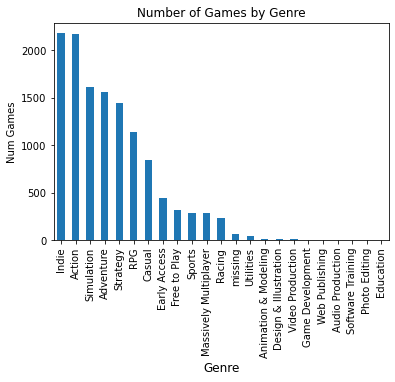

In [1195]:
df2['genre'].value_counts().plot(kind='bar',title='Number of Games by Genre')
plt.xlabel('Genre', fontsize=12)
plt.ylabel('Num Games',fontsize=10);

### 5.1.2 Percentage Distribution of Number of Games by Genre

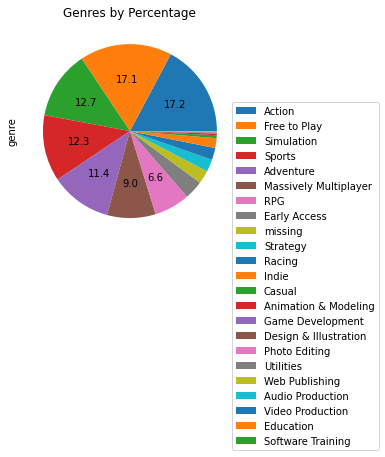

In [1205]:
df2['genre'].value_counts().plot(kind='pie',autopct=lambda x: format(x,'.1f') if x>5 else None, labels=None,title='Genres by Percentage')
plt.legend(labels=genre3,loc='center right',bbox_to_anchor=(1.1,0),bbox_transform=plt.gcf().transFigure);

### 5.1.3 Average price per Genre

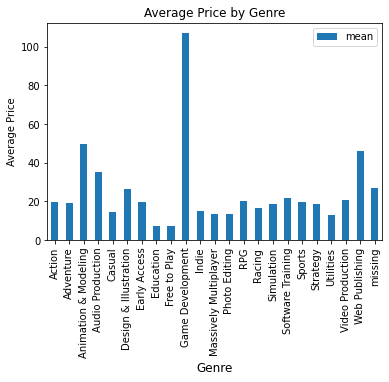

In [1202]:
df2.groupby('genre')['price'].agg(['mean']).plot(kind='bar',title='Average Price by Genre')
plt.xlabel('Genre', fontsize=12)
plt.ylabel('Average Price',fontsize=10);

### 5.2 Min, max, and average number of reviews by Steam Deck support mode

In [1188]:
df1.groupby('deck_sup')['review_count'].agg(['min','max','mean'])

,min,max,mean
deck_sup,,,
Playable,14,6685816,28112.490094
Unknown,797,21622,11209.500000
Unsupported,18,2083747,24944.067864
Verified,13,812431,20731.117175
missing,0,1289530,3031.603490


### 5.3 Min, max, and average price for each rating category

In [1203]:
df1.groupby('rating')['price'].agg(['min','max','mean'])

,min,max,mean
rating,,,
ao,6.69,6.69,6.690000
e,0.00,89.99,24.445515
e10,0.00,79.99,24.195923
m,0.00,109.99,29.505226
missing,0.00,659.00,16.720862
rp,64.99,64.99,64.990000
t,0.00,139.99,30.505315


### 5.3.1 Number of games per rating category

In [1190]:
df1.groupby('rating')['name'].agg(['count'])

,count
rating,
ao,1
e,136
e10,130
m,310
missing,4097
rp,1
t,333


### 5.4 Number of games vs Price

In [898]:
# make copy of df
g2 = df1.copy()

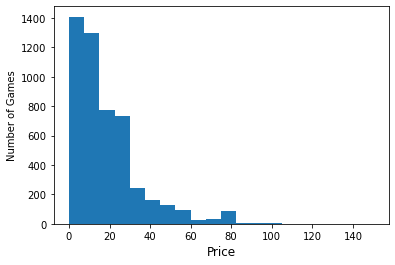

In [1206]:
g2['price'].plot(kind='hist',range=[0,150],bins=20)
plt.xlabel('Price', fontsize=12)
plt.ylabel('Number of Games',fontsize=10);

### 5.5 Reviews and Price Range

In [923]:
# find price range and compare with reviews
# first make new tables from original table separated by price range

In [931]:
g2.sort_values('price',ascending=False)

,name,price,discount_price,release_date,review_count,review_quality,genre,rating,dev,publisher,player_sup,deck_sup
6,Valve Index® Headset,659.00,659.0,missing,0,missing,missing,missing,missing,missing,missing,missing
198,Valve Index® Controllers,369.00,369.0,missing,0,missing,missing,missing,missing,missing,missing,missing
2517,Sid Meier's Civilization® VI: Nubia Civilizati...,265.35,24.5,2017-07-27 00:00:00,326,Mostly Negative,Strategy,missing,Firaxis Games,2K,Single-player,missing
1915,Sid Meier's Civilization® VI: Khmer and Indone...,265.35,24.5,2017-10-19 00:00:00,286,Mixed,Strategy,missing,Firaxis Games,2K,Single-player,missing
1749,Sid Meier's Civilization® VI: Persia and Maced...,265.35,24.5,2017-03-28 00:00:00,497,Mostly Negative,Strategy,missing,Firaxis Games,2K,Single-player,missing
...,...,...,...,...,...,...,...,...,...,...,...,...
2640,School of Dragons,0.00,0.0,2014-12-04 00:00:00,4977,Mixed,"Adventure, Free to Play, Massively Multiplayer...",e,"JumpStart Games, Inc.","JumpStart Games, Inc.",MMO,Playable
2678,Aim Lab,0.00,0.0,2018-02-07 00:00:00,77394,Very Positive,"Action, Adventure, Casual, Free to Play, Indie...",missing,Statespace,Statespace,Single-player,Unsupported
2686,Guarding Goddess,0.00,0.0,2022-09-27 00:00:00,73,Mostly Positive,"Action, Adventure, Casual, Free to Play, Indie...",missing,Goddess,Goddess,MMO,missing
2715,Toribash,0.00,0.0,2006-03-01 00:00:00,15518,Very Positive,"Action, Free to Play, Indie, Strategy",missing,Nabi Studios,"Nicalis, Inc.",Single-player,Playable


In [975]:
p1 = g2[(g2['price']>=0) & (g2['price']<10)]

In [978]:
p2 = g2[(g2['price']>=10) & (g2['price']<20)]

In [979]:
p3 = g2[(g2['price']>=20) & (g2['price']<30)]

In [980]:
p4 = g2[(g2['price']>=30) & (g2['price']<40)]

In [981]:
p5 = g2[(g2['price']>=40) & (g2['price']<50)]

In [982]:
p6 = g2[(g2['price']>=50) & (g2['price']<60)]

In [983]:
p7 = g2[(g2['price']>=60) & (g2['price']<70)]

In [984]:
p8 = g2[(g2['price']>=70) & (g2['price']<80)]

In [985]:
p9 = g2[(g2['price']>=80) & (g2['price']<100)]

In [986]:
p10 = g2[(g2['price']>=100) & (g2['price']<200)]

In [987]:
p11 = g2[g2['price']>=200]

In [961]:
p1

,name,price,discount_price,release_date,review_count,review_quality,genre,rating,dev,publisher,player_sup,deck_sup,price_range
45,ELEX II,2.49,2.49,2022-03-01 00:00:00,2224,Mostly Positive,"Action, Adventure, RPG",m,Piranha Bytes,THQ Nordic,Single-player,Unsupported,0-10
53,ELEX,2.87,2.87,2017-10-17 00:00:00,10934,Mostly Positive,"Action, Adventure, RPG",m,Piranha Bytes,THQ Nordic,Single-player,Playable,0-10
80,Sonic Mania,3.49,3.49,2017-08-29 00:00:00,17752,Very Positive,"Action, Adventure, Casual",e,Christian Whitehead,SEGA,Single-player,Verified,0-10
89,Among Us,5.69,5.69,2018-11-16 00:00:00,560343,Very Positive,Casual,missing,Innersloth,Innersloth,Online PvP,Playable,0-10
91,Travellers Rest,3.72,3.72,2020-07-28 00:00:00,3322,Very Positive,"Adventure, Casual, Indie, RPG, Simulation, Ear...",missing,Isolated Games,Isolated Games,Single-player,Verified,0-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5002,Nancy Drew®: The Haunting of Castle Malloy,7.99,7.99,2009-03-01 00:00:00,120,Very Positive,Adventure,e,HeR Interactive,HeR Interactive,Single-player,Unsupported,0-10
5003,Caravaneer 2,6.69,6.69,2014-12-07 00:00:00,293,Very Positive,"Indie, RPG, Simulation, Strategy",missing,Dmitry Zheltobriukhov,Dmitry Zheltobriukhov,Single-player,Playable,0-10
5004,Music for The Long Dark -- Volume Two,8.99,8.99,2020-05-19 00:00:00,20,Positive,missing,missing,Hinterland Studio Inc.,Hinterland Studio,missing,missing,0-10
5005,Outlaws + A Handful of Missions,6.69,6.69,1997-03-31 00:00:00,435,Very Positive,Action,missing,LucasArts,Lucasfilm,Single-player,missing,0-10


In [ ]:
# append new column to table

In [993]:
p2['price_range'] = '10-20'

C:\Users\yuki-\AppData\Local\Temp\ipykernel_34192\1654641431.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p2['price_range'] = '10-20'


In [990]:
p3['price_range'] = '20-30'

C:\Users\yuki-\AppData\Local\Temp\ipykernel_34192\68289820.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p3['price_range'] = '20-30'


In [991]:
p4['price_range'] = '30-40'

C:\Users\yuki-\AppData\Local\Temp\ipykernel_34192\208147474.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p4['price_range'] = '30-40'


In [994]:
p5['price_range'] = '40-50'

C:\Users\yuki-\AppData\Local\Temp\ipykernel_34192\3918721805.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p5['price_range'] = '40-50'


In [995]:
p6['price_range'] = '50-60'

C:\Users\yuki-\AppData\Local\Temp\ipykernel_34192\2750159277.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p6['price_range'] = '50-60'


In [996]:
p7['price_range'] = '60-70'

C:\Users\yuki-\AppData\Local\Temp\ipykernel_34192\1976013018.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p7['price_range'] = '60-70'


In [997]:
p8['price_range'] = '70-80'

C:\Users\yuki-\AppData\Local\Temp\ipykernel_34192\3369604806.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p8['price_range'] = '70-80'


In [998]:
p9['price_range'] = '80-100'

C:\Users\yuki-\AppData\Local\Temp\ipykernel_34192\229618685.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p9['price_range'] = '80-100'


In [1006]:
p10['price_range'] = '<100-200'

C:\Users\yuki-\AppData\Local\Temp\ipykernel_34192\1040686607.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p10['price_range'] = '<100-200'


In [1000]:
p11['price_range'] = '>200'

C:\Users\yuki-\AppData\Local\Temp\ipykernel_34192\1260037515.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p11['price_range'] = '>200'


In [ ]:
# combine tables into new table

In [1007]:
g3 = pd.concat([p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11])

In [ ]:
# plot average review count vs price range

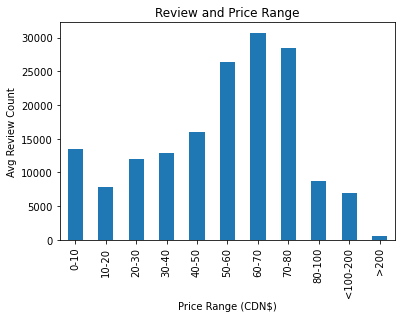

In [1207]:
g3.groupby('price_range')['review_count'].agg('mean').plot(kind='bar',title='Review and Price Range');
plt.xlabel('Price Range (CDN$)', fontsize=10)
plt.ylabel('Avg Review Count',fontsize=10);

### 5.6 Games on Discount

In [ ]:
# find out if game is on discount and append column

In [1016]:
g2[g2['discount_price'] != g2['price']]

,name,price,discount_price,release_date,review_count,review_quality,genre,rating,dev,publisher,player_sup,deck_sup
14,Fallout 4,26.99,6.74,2015-11-10 00:00:00,183508,Very Positive,RPG,m,Bethesda Game Studios,Bethesda Softworks,Single-player,Playable
18,Total War: WARHAMMER II,71.99,24.47,2017-09-28 00:00:00,79102,Very Positive,"Action, Strategy",t,CREATIVE ASSEMBLY,SEGA,Single-player,Playable
21,No Man's Sky,66.49,33.24,2016-08-12 00:00:00,191469,Mostly Positive,"Action, Adventure",missing,Hello Games,Hello Games,Single-player,missing
23,HUMANKIND™,61.99,30.99,2021-08-17 00:00:00,16094,Mixed,Strategy,e10,AMPLITUDE Studios,SEGA,Single-player,Playable
28,American Truck Simulator,24.99,6.24,2016-02-02 00:00:00,89477,Overwhelmingly Positive,"Indie, Simulation",missing,SCS Software,SCS Software,Single-player,Playable
...,...,...,...,...,...,...,...,...,...,...,...,...
4993,CoH 2 - German Commander: Encirclement Doctrine,4.49,1.12,2014-09-09 00:00:00,17,Positive,Strategy,missing,Relic Entertainment,SEGA,Single-player,missing
4994,CoH 2 - Soviet Commander: Soviet Industry Tactics,4.49,1.12,2013-11-12 00:00:00,35,Mixed,Strategy,missing,Relic Entertainment,SEGA,Single-player,missing
4995,CoH 2 - OKW Commander: Fortifications Doctrine,4.49,1.12,2014-07-23 00:00:00,36,Positive,Strategy,missing,Relic Entertainment,SEGA,Single-player,missing
5001,ENDLESS™ Space 2 - Original Soundtrack,7.70,3.85,2020-07-03 00:00:00,4,Other,Strategy,missing,AMPLITUDE Studios,SEGA,missing,missing


In [1030]:
# assign to new table
d1 = g2[g2['discount_price'] != g2['price']]

In [1031]:
# add new column to indicate if game is on sale
d1['on_discount'] = 'Yes'

C:\Users\yuki-\AppData\Local\Temp\ipykernel_34192\285556358.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d1['on_discount'] = 'Yes'


In [1027]:
d2 = g2[g2['discount_price'] == g2['price']]

In [1029]:
d2['on_discount'] = 'No'

C:\Users\yuki-\AppData\Local\Temp\ipykernel_34192\652282144.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d2['on_discount'] = 'No'


In [1023]:
# calculate the percentage of discount
def find_discount(p,dp):
    return round((p-dp)/p *100)

In [1035]:
d1['percentage_discount'] = d1[['price','discount_price']].apply(lambda x: find_discount(x['price'],x['discount_price']),axis=1)

C:\Users\yuki-\AppData\Local\Temp\ipykernel_34192\178073348.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d1['percentage_discount'] = d1[['price','discount_price']].apply(lambda x: find_discount(x['price'],x['discount_price']),axis=1)


In [1037]:
d2['percentage_discount'] = 0

C:\Users\yuki-\AppData\Local\Temp\ipykernel_34192\905582899.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d2['percentage_discount'] = 0


In [ ]:
# combine and save as new table
t_disc = pd.concat([d1,d2])
t_disc.reset_index(drop=True)

In [ ]:
# plot average review count vs if game is on discount

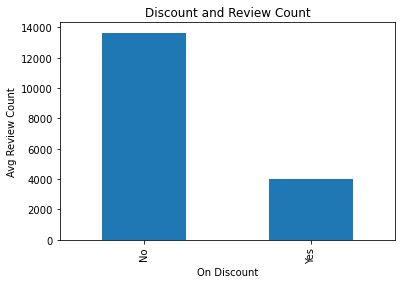

In [1208]:
t_disc.groupby('on_discount')['review_count'].agg('mean').plot(kind='bar',title='Discount and Review Count')
plt.xlabel('On Discount', fontsize=10)
plt.ylabel('Avg Review Count',fontsize=10);

In [1211]:
# Games with the most discounts
t_disc.sort_values('percentage_discount',ascending=False).head(10)

,name,price,discount_price,release_date,review_count,review_quality,genre,rating,dev,publisher,player_sup,deck_sup,on_discount,percentage_discount
2868,Sid Meier's Civilization® VI: Australia Civili...,265.35,24.50,2017-02-23 00:00:00,759,Mixed,Strategy,missing,Firaxis Games,2K,Single-player,missing,Yes,91
1915,Sid Meier's Civilization® VI: Khmer and Indone...,265.35,24.50,2017-10-19 00:00:00,286,Mixed,Strategy,missing,Firaxis Games,2K,Single-player,missing,Yes,91
1749,Sid Meier's Civilization® VI: Persia and Maced...,265.35,24.50,2017-03-28 00:00:00,497,Mostly Negative,Strategy,missing,Firaxis Games,2K,Single-player,missing,Yes,91
2517,Sid Meier's Civilization® VI: Nubia Civilizati...,265.35,24.50,2017-07-27 00:00:00,326,Mostly Negative,Strategy,missing,Firaxis Games,2K,Single-player,missing,Yes,91
2866,Sid Meier's Civilization® VI: Vikings Scenario...,265.35,24.50,2016-12-20 00:00:00,1171,Overwhelmingly Negative,Strategy,missing,Firaxis Games,2K,Single-player,missing,Yes,91
2872,Sid Meier's Civilization® VI: Poland Civilizat...,265.35,24.50,2016-12-20 00:00:00,818,Mostly Negative,Strategy,missing,Firaxis Games,2K,Single-player,missing,Yes,91
4065,The Emerald Maiden: Symphony of Dreams,10.99,1.09,2016-02-18 00:00:00,223,Very Positive,"Adventure, Casual",missing,Gogii Games,Artifex Mundi,Single-player,missing,Yes,90
537,NARUTO TO BORUTO: SHINOBI STRIKER,79.99,7.99,2018-08-31 00:00:00,36635,Very Positive,Action,t,Soleil Ltd.,BANDAI NAMCO Entertainment,Single-player,Unsupported,Yes,90
4340,Queen's Quest: Tower of Darkness,10.99,1.09,2015-09-10 00:00:00,170,Mixed,"Adventure, Casual",missing,Brave Giant LTD,Artifex Mundi,Single-player,Unsupported,Yes,90
4630,Queen's Quest: Tower of Darkness,10.99,1.09,2015-09-10 00:00:00,170,Mixed,"Adventure, Casual",missing,Brave Giant LTD,Artifex Mundi,Single-player,Unsupported,Yes,90


### 5.7 Number of Games by Review Quality

In [1049]:
t_disc.groupby(['review_quality','on_discount'])['name'].agg('count').unstack()

on_discount,No,Yes
review_quality,,
Mixed,608.0,130.0
Mostly Negative,63.0,21.0
Mostly Positive,669.0,114.0
Negative,4.0,NaN
Other,148.0,73.0
Overwhelmingly Negative,1.0,1.0
Overwhelmingly Positive,395.0,30.0
Positive,309.0,72.0
Very Negative,1.0,2.0


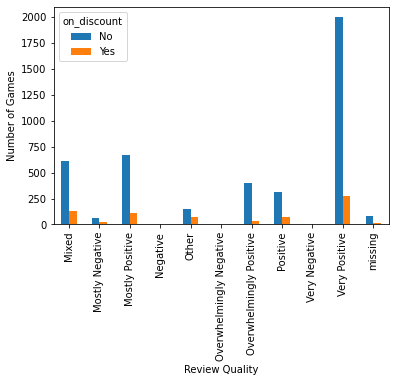

In [1053]:
# plot number of games vs review quality, for both games on sale and not on sale
t_disc.groupby(['review_quality','on_discount'])['name'].agg('count').unstack().plot(kind='bar')
plt.xlabel('Review Quality', fontsize=10)
plt.ylabel('Number of Games',fontsize=10);

### 5.8 Game Price and Release Date

In [1102]:
# make copy of table for release date, and filter items that have a release date
g5 = g3[g3['release_date'] != 'missing']

In [1103]:
# convert to datetime format
g5['release_date'] = g5['release_date'].apply(lambda x:datetime.datetime.strptime(x[:10],'%Y-%m-%d'))

C:\Users\yuki-\AppData\Local\Temp\ipykernel_34192\4278786022.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  g5['release_date'] = g5['release_date'].apply(lambda x:datetime.datetime.strptime(x[:10],'%Y-%m-%d'))


In [1107]:
# find the year of release for each game
g5['release_year'] = g5['release_date'].map(lambda x:x.year)

C:\Users\yuki-\AppData\Local\Temp\ipykernel_34192\3651603617.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  g5['release_year'] = g5['release_date'].map(lambda x:x.year)


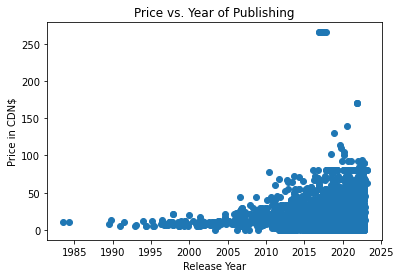

In [1213]:
# plot price vs release year
plt.scatter(g5['release_date'],g5['price'])
plt.title('Price vs. Year of Publishing')
plt.xlabel('Release Year', fontsize=10)
plt.ylabel('Price in CDN$',fontsize=10);

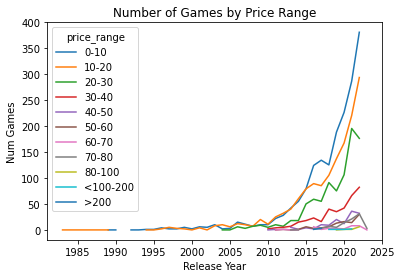

In [1215]:
# Number of Games for each Price Range vs. Release Year
g5.groupby(['release_year','price_range'])['name'].agg('count').unstack().plot(title='Number of Games by Price Range')
plt.xlabel('Release Year', fontsize=10)
plt.ylabel('Num Games',fontsize=10);

### 5.9 Publisher and Reviews

In [1130]:
# publisher with the most games
t_disc.groupby('publisher')['name'].agg('count').reset_index(name='count').sort_values('count', ascending=False).head(10)

,publisher,count
1078,SEGA,214
1470,missing,193
952,Paradox Interactive,127
388,Electronic Arts,122
9,2K,87
1176,Square Enix,81
1331,Ubisoft,75
1152,Slitherine Ltd.,71
103,BANDAI NAMCO Entertainment,62
1228,THQ Nordic,57


### 5.9.1 Select publishers that make the most games and analyse their reviews

In [1133]:
pub1 = t_disc[t_disc['publisher']=='SEGA']

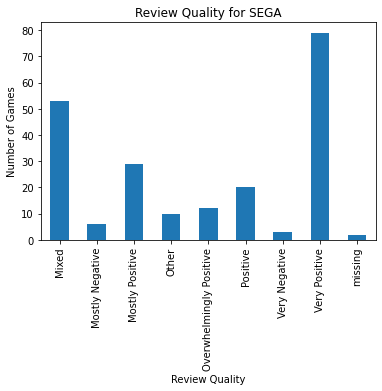

In [1141]:
pub1.groupby('review_quality')['name'].agg('count').plot(kind='bar',title='Review Quality for SEGA')
plt.xlabel('Review Quality', fontsize=10)
plt.ylabel('Number of Games',fontsize=10);

In [1137]:
pub2 = t_disc[t_disc['publisher']=='Paradox Interactive']

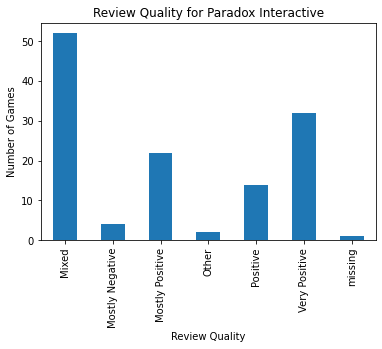

In [1142]:
pub2.groupby('review_quality')['name'].agg('count').plot(kind='bar',title='Review Quality for Paradox Interactive')
plt.xlabel('Review Quality', fontsize=10)
plt.ylabel('Number of Games',fontsize=10);

In [1139]:
pub3 = t_disc[t_disc['publisher']=='Electronic Arts']

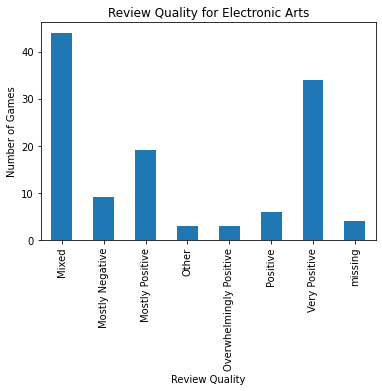

In [1143]:
pub3.groupby('review_quality')['name'].agg('count').plot(kind='bar',title='Review Quality for Electronic Arts')
plt.xlabel('Review Quality', fontsize=10)
plt.ylabel('Number of Games',fontsize=10);

In [1148]:
pub4 = t_disc[t_disc['publisher']=='Square Enix']

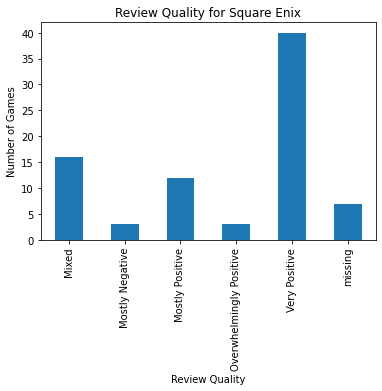

In [1145]:
pub4.groupby('review_quality')['name'].agg('count').plot(kind='bar',title='Review Quality for Square Enix')
plt.xlabel('Review Quality', fontsize=10)
plt.ylabel('Number of Games',fontsize=10);

In [1147]:
pub5 = t_disc[t_disc['publisher']=='Ubisoft']

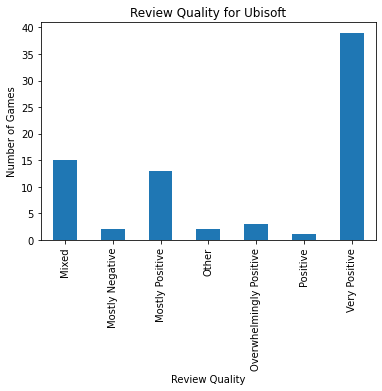

In [1149]:
pub5.groupby('review_quality')['name'].agg('count').plot(kind='bar',title='Review Quality for Ubisoft')
plt.xlabel('Review Quality', fontsize=10)
plt.ylabel('Number of Games',fontsize=10);

In [1150]:
pub6 = t_disc[t_disc['publisher']=='2K']

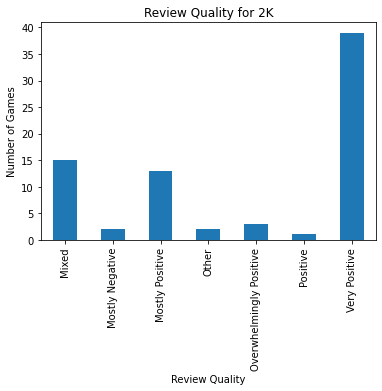

In [1151]:
pub5.groupby('review_quality')['name'].agg('count').plot(kind='bar',title='Review Quality for 2K')
plt.xlabel('Review Quality', fontsize=10)
plt.ylabel('Number of Games',fontsize=10);